# Анализ бизнес-показателей приложения Procrastinate Pro+.

Развлекательное приложения Procrastinate Pro+, несмотря на огромные вложения в рекламу, последние несколько месяцев терпит убытки. Задача — разобраться в причинах и помочь компании выйти в плюс.
Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
лог сервера с данными об их посещениях,
выгрузка их покупок за этот период,
рекламные расходы.


В ходе анализа изучим:
 - откуда приходят пользователи и какими устройствами они пользуются,
 - сколько стоит привлечение пользователей из различных рекламных каналов;
 - сколько денег приносит каждый клиент,
 - когда расходы на привлечение клиента окупаются,
 - какие факторы мешают привлечению клиентов.
 
 
Описание данных:


visits_info_short.csv:
- *User Id* — уникальный идентификатор пользователя,
- *Region* — страна пользователя,
- *Device* — тип устройства пользователя,
- *Channel* — идентификатор источника перехода,
- *Session Start* — дата и время начала сессии,
- *Session End* — дата и время окончания сессии.


orders_info_short.csv:
- *User Id* — уникальный идентификатор пользователя,
- *Event Dt* — дата и время покупки,
- *Revenue* — сумма заказа.


costs_info_short.csv:
- *dt* — дата проведения рекламной кампании,
- *Channel* — идентификатор рекламного источника,
- *costs* — расходы на эту кампанию.

### Загрузим данные и подготовим их к анализу.

#### Импортируем библиотеки. Считаем данные из csv-файлов в датафреймы . 

In [1]:
import pandas as pd
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import numpy as np

In [2]:
sessions = pd.read_csv('visits_info_short.csv')
orders = pd.read_csv('orders_info_short.csv')
costs = pd.read_csv('costs_info_short.csv')

In [3]:
display(sessions.head())
display(orders.head())
costs.head()

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


#### Преобразуем тип данных в столбцах времени и даты.

In [4]:
sessions['Session Start'] = pd.to_datetime(sessions['Session Start'])
sessions['Session End'] = pd.to_datetime(sessions['Session End'])
orders['Event Dt'] = pd.to_datetime(orders['Event Dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

#### Изучим пропуски и дубликаты.

In [5]:
data = [sessions, orders, costs] #создадим список таблиц
#применим цикл для вывода на экран информации о количестве пропуском и дубликатов
for index in data:
    print('Пропущенные значения в таблице')
    print(index.isna().sum())
    print()
    print('Количество дубликатов:', index.duplicated().sum())
    print()

Пропущенные значения в таблице
User Id          0
Region           0
Device           0
Channel          0
Session Start    0
Session End      0
dtype: int64

Количество дубликатов: 0

Пропущенные значения в таблице
User Id     0
Event Dt    0
Revenue     0
dtype: int64

Количество дубликатов: 0

Пропущенные значения в таблице
dt         0
Channel    0
costs      0
dtype: int64

Количество дубликатов: 0



### Зададим функции для расчёта и анализа LTV, ROI, удержания и конверсии.


In [6]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['User Id', 'Session Start'])
        .groupby('User Id')
        .agg(
            {
                'Session Start': 'first',
                'Channel': 'first',
                'Device': 'first',
                'Region': 'first',
            }
        )
        .rename(columns={'Session Start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['User Id'].isin(orders['User Id'].unique())


    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'Channel'])
        .agg({'User Id': 'nunique'})
        .rename(columns={'User Id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = costs.merge(new_users, on=['dt', 'Channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'Channel', 'acquisition_cost']],
        on=['dt', 'Channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles
 

In [7]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['User Id', 'Session Start']], on='User Id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['Session Start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='User Id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'User Id': 'nunique'})
            .rename(columns={'User Id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [8]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):
   
    
    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['User Id', 'Event Dt'])
        .groupby('User Id')
        .agg({'Event Dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['User Id', 'Event Dt']], on='User Id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['Event Dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='User Id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'User Id': 'nunique'})
            .rename(columns={'User Id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [9]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['User Id', 'Event Dt', 'Revenue']], on='User Id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['Event Dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='Revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'User Id': 'nunique'})
            .rename(columns={'User Id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['User Id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

In [10]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [11]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=14):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [12]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=14):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [13]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=14):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

### Исследовательский анализ данных


#### Получим профили пользователей.

Для этого вызовем функцию get_profiles(), передав ей данные о визитах, заказах и тратах на рекламу развлекательного приложения Procrastinate Pro+.

In [14]:
profiles = get_profiles(sessions, orders, costs)
display(profiles.head(5))

,User Id,first_ts,Channel,Device,Region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [15]:
profiles['dt'].min()#узнаем минимальную дату привлечения пользователей

datetime.date(2019, 5, 1)

In [16]:
profiles['dt'].max()#узнаем максимальную дату привлечения пользователей

datetime.date(2019, 10, 27)

Мы располагаем данным о клиентах, привлечённых с 1 мая по 27 октября 2019 года. Момент анализа - 1 ноября 2019 года, в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. При расчете и анализе показателей установим горизонт анализа, равный 14 дням. Отфильтруем данные, чтобы при расчете бизнес показателей участвовали только те пользователи, которые пользовались приложением не менее 14 дней.

#### Проанализируем распределение платящих пользователей в разрезе:
##### Стран.

In [17]:
(profiles.groupby('Region').agg({'User Id': 'nunique', 'payer': 'mean'})
         .sort_values(by = 'payer', ascending = False))

,User Id,payer
Region,,
United States,100002,0.069019
Germany,14981,0.041119
UK,17575,0.039829
France,17450,0.037994


В данных представлены пользователи из 4 стран: США, Германия, Великобритания и Франция. Более 66% пользователей из США, что составляет 100 002 человека. На остальные страны приходится по 10% пользователей. Так же США лидирует по количеству платящих пользователей, почти 7% пользователей из страны совершили покупку в приложении. Доля платящих в других странах равна 4%.
##### Устройств.

In [18]:
(profiles.groupby('Device').agg({'User Id': 'nunique', 'payer': 'mean'})
         .sort_values(by = 'payer', ascending = False))

,User Id,payer
Device,,
Mac,30042,0.063644
iPhone,54479,0.062079
Android,35032,0.058518
PC,30455,0.050468


Пользователи из имеющихся данных используют 4 вида устройств: Mac, Iphone, Android, PC. Почти 55 тысяч пользователей пользующиеся приложениям используют его на Iphone доля платящих из них равна 6,2%. Наименьшее количество пользователей используют тип устройств Mac - 30042 пользователей, но клиенты с Mac чаще всех совершают покупки, доля платящих равна 6,3%.  
##### Рекламных источников привлечения.

In [19]:
channel_prof = (profiles.groupby('Channel').agg({'User Id': 'nunique', 'payer': 'mean'})
                        .sort_values(by = 'payer', ascending = False))
channel_prof['payer'] = channel_prof['payer'].apply('{:.2%}'.format)
channel_prof

,User Id,payer
Channel,,
FaceBoom,29144,12.20%
AdNonSense,3880,11.34%
lambdaMediaAds,2149,10.47%
TipTop,19561,9.60%
RocketSuperAds,4448,7.91%
WahooNetBanner,8553,5.30%
YRabbit,4312,3.83%
MediaTornado,4364,3.57%
LeapBob,8553,3.06%


Более 56 тысяч человек скачали приложение органически, без рекламы, платящих из таких пользователей всего 2%. Реклама через FaceBoom привлекла 29144 клиентов, наибольшая доля платящих пользователей пришла из этого источника, и равна 12,2%. AdNonSense привлек 3880 пользователей, но доля платящих так же высока и равна 11,3%.

### Маркетинг


In [20]:
display('Общие расходы на привлечение : {:.2f}'.format(costs['costs'].sum()))
costs.groupby('Channel').agg({'costs': 'sum'}).sort_values(by = 'costs', ascending = False)

'Общие расходы на привлечение : 105497.30'

,costs
Channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


Руководством приложения Procrastinate Pro+ было потрачено 105 тысяч на рекламные кампании. Из них примерно 50% было вложено в TipTop. Так же крупные вложения были в рекламу через FaceBoom - 32445,6.

Проанализируем динамику изменения расходов по каждому источнику.

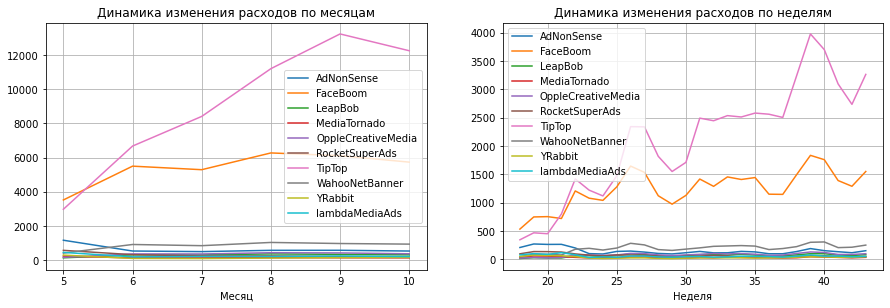

In [21]:
c = costs

c['dt'] = pd.to_datetime(c['dt'])
c['week'] = c['dt'].dt.isocalendar().week
c['month'] = c['dt'].dt.month
plt.figure(figsize=(15, 10))
ax1 = plt.subplot(2, 2, 1)
c.pivot_table(index='month', columns='Channel', values='costs', aggfunc='sum').plot(grid=True, ax=ax1)
plt.legend()
plt.xlabel('Месяц')
plt.title('Динамика изменения расходов по месяцам')


ax2 = plt.subplot(2, 2, 2)
c.pivot_table(index='week', columns='Channel', values='costs', aggfunc='sum').plot(grid=True, ax=ax2)
plt.legend()
plt.xlabel('Неделя')
plt.title('Динамика изменения расходов по неделям')

plt.show()



На большинство рекламных компаний ежемесячно выделялись одинаковые суммы, кроме таких источников как TipTop и FaceBoom. Расходы на рекламу через TipTop увеличивались ежемесячно примерно на 3000. В сентябре расходы на этот источник достигли 13000, в то время как на большинство источников выделялось не более 1500. На рекламу через FaceBoom с начала анализируемого периода вкладывалось значительно больше, чем в остальные источники, расходы с мая по октябрь варьировались от 3500 до 6000.

In [22]:
(profiles.groupby('Channel').agg({'acquisition_cost' : 'mean'})
        .sort_values('acquisition_cost'))

,acquisition_cost
Channel,
organic,0.000000
LeapBob,0.210172
MediaTornado,0.218717
YRabbit,0.218975
OppleCreativeMedia,0.250000
RocketSuperAds,0.412095
WahooNetBanner,0.602245
lambdaMediaAds,0.724802
AdNonSense,1.008054


Стоимость привлечения «органических» пользователей равна нулю, потому что они перешли в приложение самостоятельно, а не благодаря рекламе. Привлечение одного пользователя из рекламной капмании в  TipTop обошлось компании в среднем в 2,8, а из FaceBoom — примерно в 1,1.

### Оценим окупаемость рекламы.

Используя графики LTV, ROI и CAC, проанализируйте окупаемость рекламы. Считайте, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. Необходимость включения в анализ органических пользователей определите самостоятельно.

- Проанализируйте окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проверьте конверсию пользователей и динамику её изменения. То же самое сделайте с удержанием пользователей. Постройте и изучите графики конверсии и удержания.
- Проанализируйте окупаемость рекламы с разбивкой по устройствам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по странам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Ответьте на такие вопросы:
    - Окупается ли реклама, направленная на привлечение пользователей в целом?
    - Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
    - Чем могут быть вызваны проблемы окупаемости?

Напишите вывод, опишите возможные причины обнаруженных проблем и промежуточные рекомендации для рекламного отдела.

#### Установим момент и горизонт анализа данных. 

На календаре 1 ноября 2019 года,  зададим недельный горизонт анализа равный 14 дням. Стоимость привлечения «органических» пользователей равна нулю, потому что они перешли в приложение самостоятельно, а не благодаря рекламе. Так как такие клиенты составляют 1/3 от общего числа пользователей, то их наличие может исказить показатели окупаемости. Очистим данные и удалим клиентов, пришедших органически.

In [23]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа 
profiles = profiles[profiles['Channel'] != 'organic']

#### Для начала оценим общую ситуацию — посмотрим на окупаемость рекламы. Рассчитаем и визуализируем LTV и ROI.

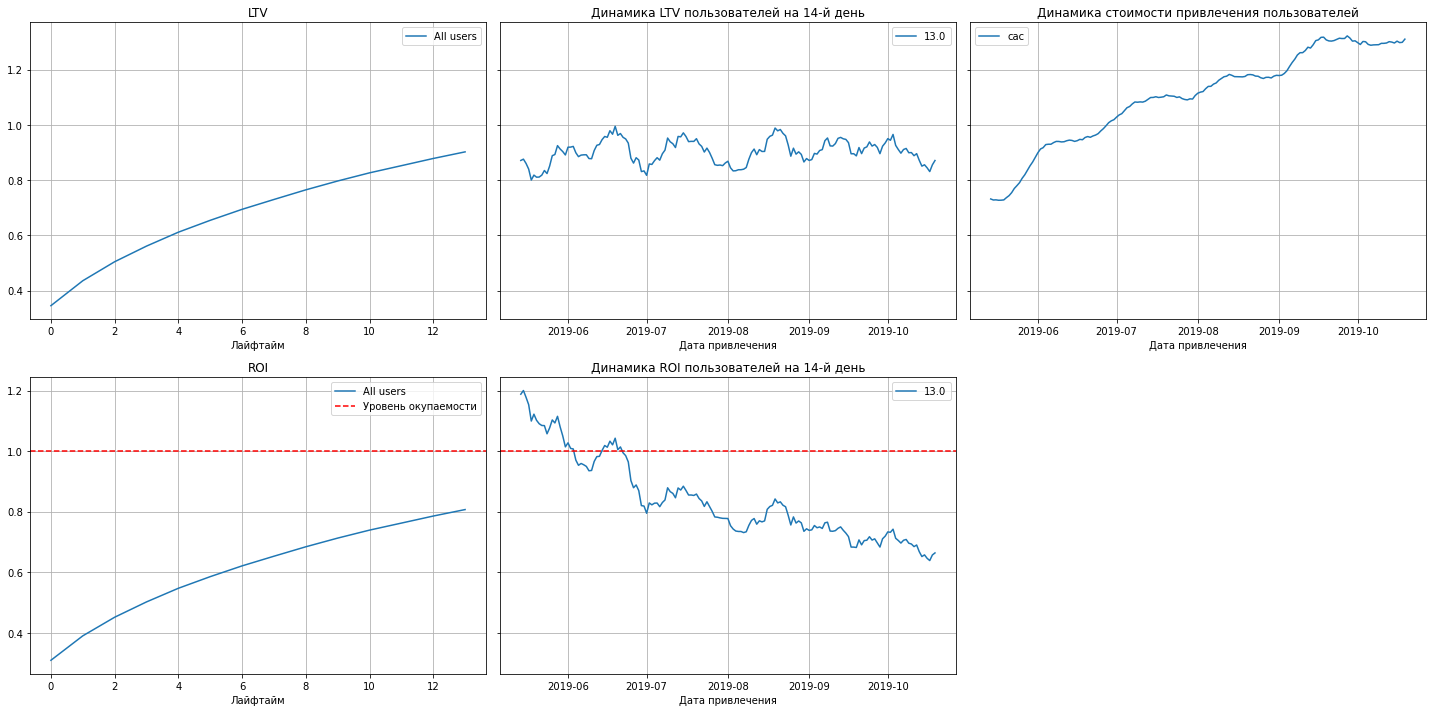

In [24]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

По графикам можно сделать вывод, что реклама не окупается в течение 14 дней как было запланировано в бизнес-плане,в конце второй недели показатель ROI достигает 80%. Динамика стоимости привлечения пользователей растет, руководство компании увеличивало расходы на рекламу ежемесячно. Если рассмотреть график динамики ROI, то можно сделать выводы, что первый месяц пользователи окупались. Далее показатель ROI снижался. LTV достаточно стабилен, резкого ухудшения или улучшения качества пользователей не происходило.

#### Проанализируем конверсию и удержание пользователей.

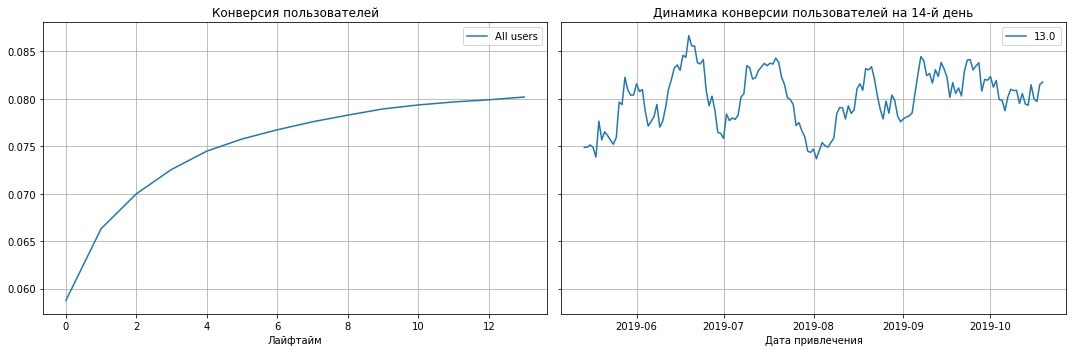

In [25]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Можно сделать вывод, что в середине месяца пользователи чаще конвертируются, в середине июня конверся была максимальной и достигала 8,6%.

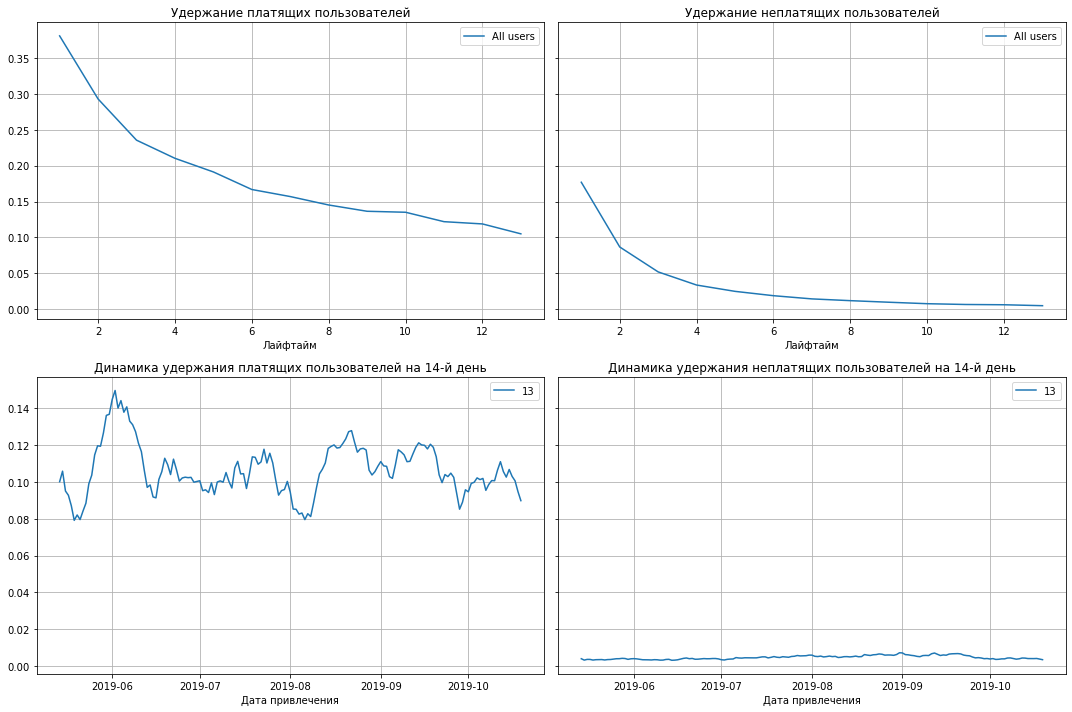

In [26]:
#удержание пользователей

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, sessions, observation_date, horizon_days
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Максимальным показатель удержания платящих пользователей был в июне и ровнялся 15%. В середине июня можно наблюдать резкое снижение показателя. С середины августа показатель стал более стабильным и менялся от 10% до 14%.

#### Проанализируем окупаемость рекламы с разбивкой по:
##### Устройствам.

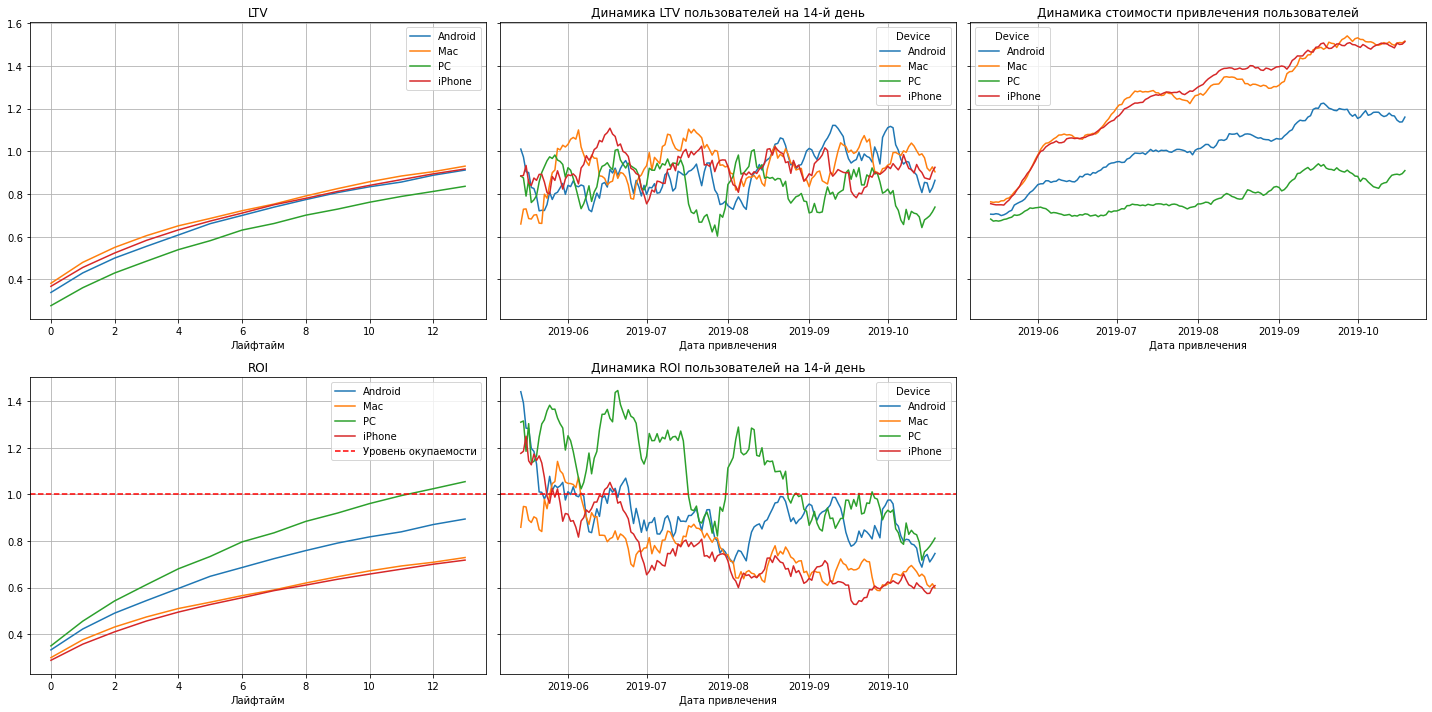

In [27]:
# смотрим окупаемость с разбивкой по устройствам

dimensions = ['Device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Пользователи PC  превышают порог окупаемости на 11 день. Пользователи Mac и Iphone не достигают порога окупаемости, на 14 день ROI равен лишь 70%. Пользователи Android так же не окупаются, показатель окупаемости к 14му дню не превышает 90%. Положительную динамику показателя ROI владельцы PC показывают на протяжении первых трех месяцев. Пользователи остальных девайсов демонстрируют практически одинаковую отрицательную динамику показателя окупаемости. Пожизненная ценность примерно одинаковая у всех пользователей девайсов. Расходы на рекламу для пользователей Mac и  Iphone значительно выше остальных, что и привело к низкому показателю их окупаемости.



##### Странам.

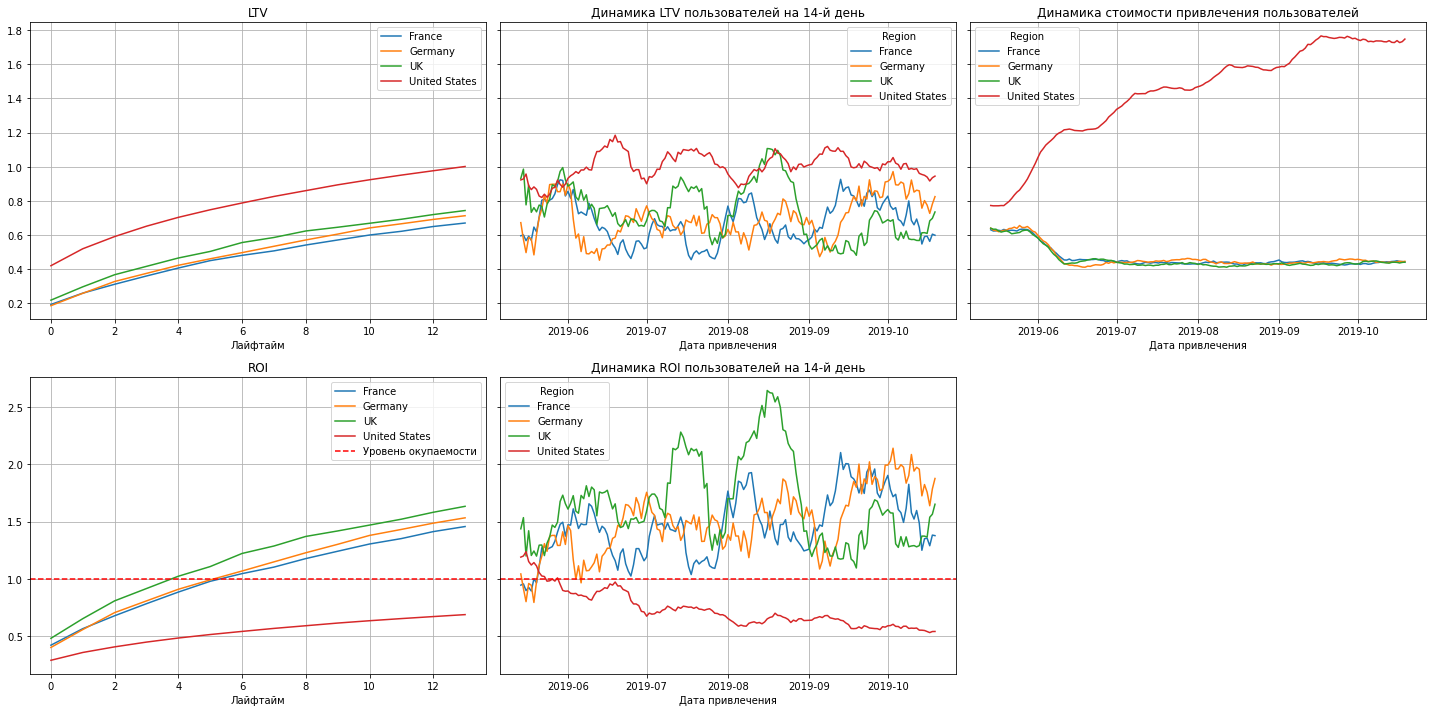

In [28]:
# смотрим окупаемость с разбивкой по странам

dimensions = ['Region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

Пользователи из Франции, Германии и Великобритании окупаются на 4-6 дни. А клиенты из США не окупаются и к 14му дню, показатель ROI достигает лишь 60%. Динамика окупаемости явно демонстрирует аутсайдера, это США, с июня она отрицательна, показатель не достигал 100%. В то же время качество пользователей из США в два раза выше остальных стран. Дело в расходах на рекламу. САС у клиентов из Франции, Германии и Великобритании стабилен с июля по октябрь, а у американцев растет, САС за пол года вырос в три раза.  


##### Рекламным каналам.

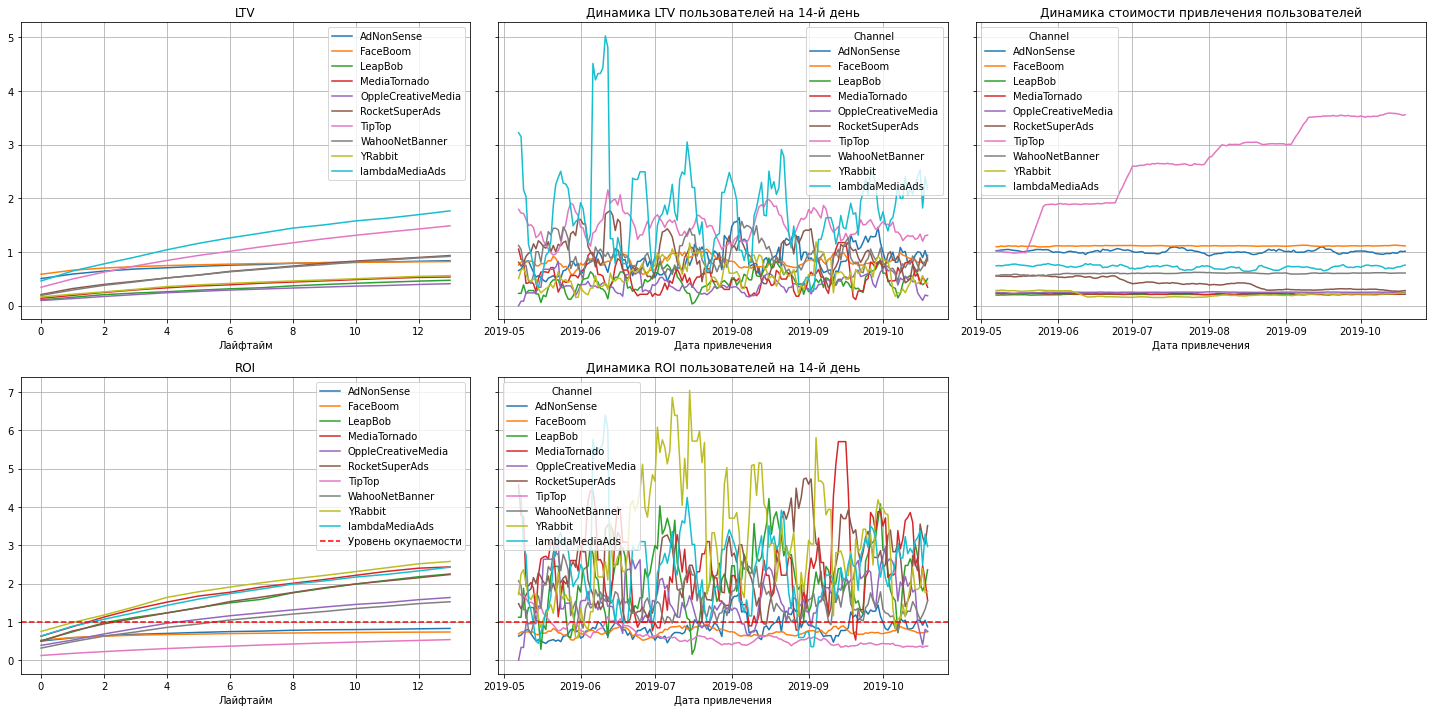

In [29]:
# смотрим окупаемость с разбивкой по источникам привлечения

dimensions = ['Channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=7
)

Пользователи пришедшие из рекламных источников TipTop, lambdaMediaAds чаще совершают покупки, показатель LTV таких пользователей в два раза выше к 14му дню. Остальные источники показывают примерно одинаковую динамику "пожизненной ценности". Расходы для всей рекламных каналов стабильны на протяжении полугода, кроме TipTop, рекламные расходы выросли в несколько раз, но это не повлекло увеличение показателя окупаемости. ROI пришедших из TipTop к 14му дню не превысил порога окупаемости, а едва достиг 60%. Минимальные расходы на рекламу были на рекламный канал YRabbit, показатель LTV таких пользователей средний по отношению к остальным источником, но окупаемость таких клиентов максимальна. Такие пользователи окупаются уже на 2 день и показатель ROI в конце второй недели стремится к 300%. Так же стоит заметить, что пик окупаемости пользователей пришедших из YRabbit приходится на период с июля по август, когда расходы на рекламу немного снизились по этому источнику.

###  Выводы

- Выделите причины неэффективности привлечения пользователей.
- Сформулируйте рекомендации для отдела маркетинга.

1. В данных о клиентах, привлечённых с 1 мая по 27 октября 2019 года, представлены пользователи из 4 стран: США, Германия, Великобритания и Франция. Более 66% пользователей из США, что составляет 100 002 человека. На остальные страны приходится по 10% пользователей. Так же США лидирует по количеству платящих пользователей, почти 7% пользователей из страны совершили покупку в приложении. Доля платящих в других странах равна 4%.

2. Пользователи из имеющихся данных используют 4 вида устройств: Mac, Iphone, Android, PC. Почти 55 тысяч пользователей пользующиеся приложениям используют его на Iphone доля платящих из них равна 6,2%. Наименьшее количество пользователей используют тип устройств Mac - 30042 пользователей, но клиенты с Mac чаще всех совершают покупки, доля платящих равна 6,3%. 

3. Более 56 тысяч человек скачали приложение самостоятельно, без рекламы, платящих из таких пользователей всего 2%. Реклама через FaceBoom привлекла 29144 клиентов, наибольшая доля платящих пользователей пришла из этого источника, и равна 12,2%. AdNonSense привлек 3880 пользователей, но доля платящих так же высока и равна 11,3%.

4. Руководством приложения Procrastinate Pro+ было потрачено 105 тысяч на рекламные кампании. Из них примерно 50% было вложено в TipTop. Так же крупные вложения были в рекламу через FaceBoom - 32445,6.

5. На большинство рекламных каналов ежемесячно выделялись одинаковые суммы, кроме таких источников как TipTop и FaceBoom. Расходы на рекламу через TipTop увеличивались ежемесячно примерно на 3000. В сентябре расходы на этот источник достигли 13000, в то время как на большинство источников выделялось не более 1500. На рекламу через FaceBoom с начала анализируемого периода вкладывалось значильно больше, чем в остальные источники, расходы с мая по октябрь варьировались от 3500 до 6000.

6. Привлечение одного пользователя из рекламной капмании в  TipTop обошлось компании в среднем в 2,8, а из FaceBoom — примерно в 1,1.

7. Реклама не окупается в течение 14 дней как было запланировано в бизнес-плане, в конце второй недели показатель ROI достигает 80%. Динамика стоимости привлечения пользователей растет, руководство компании увеличивало расходы на рекламу ежемесячно. Первый месяц пользователи окупались. Далее показатель ROI снижался. LTV достаточно стабилен, резкого ухудшения или улучшения качества пользователей не происходило.

8. В середине месяца пользователи чаще конвертируются в платящих, в середине июня конверсия была максимальной и достигала 8.6%.

9. Максимальным показатель удержания платящих пользователей был в июне и равнялся 15%. В середине июня можно наблюдать резкое снижение показателя. С середины августа показатель стал более стабильным и менялся от 10% до 14%.


10. Пользователи PC  превышают порог окупаемости на 11 день, владельцы Android на 11. Пользователи Mac и Iphone не достигают порога окупаемости, на 14 день ROI равен лишь 70%. Пользователи Android так же не окупаются, показатель окупаемости к 14му дню не превышает 90%. Положительную динамику показателя ROI владельцы PC показывают на протяжении первых трех месяцев. Пользователи остальных девайсов демонстрируют практически одинаковую отрицательную динамику показателя окупаемости. Пожизненная ценность примерно одинаковая у всех пользователей девайсов. Расходы на рекламу для пользователей Mac и  Iphone значительно выше остальных, что и привело к низкому показателю их окупаемости.


11. Пользователи из Франции, Германии и Великобритании окупаются на 4-6 дни. А клиенты из США не окупаются и к 14му дню, показатель ROI достигает лишь 60%. Динамика окупаемости явно демонстрирует аутсайдера, это США, с июня она отрицательна, показатель не достигал 100%. В то же время качество пользователей из США в два раза выше остальных стран. Дело в расходах на рекламу. САС у клиентов из Франции, Германии и Великобритании стабилен с июля по октябрь, а у американцев растет, САС за пол года вырос в три раза.  

12. Пользователи пришедшие из рекламных источников TipTop, lambdaMediaAds чаще совершают покупки, показатель LTV таких пользователей в два раза выше к 14му дню. Остальные источники показывают примерно одинаковую динамику "пожизненной ценности". Расходы для всех рекламных каналов стабильны на протяжении полугода, кроме TipTop, рекламные расходы выросли в несколько раз, но это не повлекло увеличение показателя окупаемости. ROI пришедших из TipTop к 14му дню не превысил порога окупаемости, а едва достиг 60%. Минимальные расходы на рекламу были на рекламный канал YRabbit, показатель LTV таких пользователей средний по отношению к остальным источником, но окупаемость таких клиентов максимальна. Такие пользователи окупаются уже на 2 день и показатель ROI в конце второй недели стремится к 300%. Так же стоит заметить, что пик окупаемости пользователей пришедших из YRabbit приходится на период с июля по август, когда расходы на рекламу немного снизились по этому источнику.


Руководство приложения придерживалось довольно агрессивной политики при расходовании средств на рекламу. Увеличение расходов в трое лишь на один рекламный канал не повлекло за собой увеличение продаж. Так же при расходовании средств на клиентов из разных стран был выбран узконаправленный вектор на США. Американцы чаще других пользователей совершали покупки с первых дней запуска приложения, но многократное увеличение расходов на них не повлекло соответствующего увеличения продаж в приложении.
Стоит обратить внимание, что стабильное расходование средств на другие рекламные каналы  в течение полугода показывали положительную динамику окупаемости пользователей. Руководству приложения стоит рассмотреть возможность равномерного и равнозначного расходования средств на разные рекламные кампании. Так же уделить внимание клиентам из Великобритании, так в течении рассматриваемого периода пользователи из этой страны демонстрировали положительную динамику показателя окупаемости.


Так же можно повысить удержание для пользователей из США, например с помощью введения персонализированных UX-стратегий, e-mail рассылок, персональных рекомендаций, push-уведомлений. Можно ввести определённые "награды" или привилегии для постоянных пользователей. Для канала FaceBoom можно настроить более таргетированное привлечение, направленное на пользователей с необходимыми характеристиками. Также, можно ввести поощрение пользователей за репосты контента и прочий социальный engagement, связанный с приложением, в данном канале.
